# Project

**Instructions:**

- Data:
    * Train: use a sub-set of the Non-Fraud samples.
    * Validate: use a second sub-set of the Non-Fraud samples.
    * Test: use a balanced set of samples including fraud and No-Fraud.

1. Reorganize the code form the Session 4a to create a latent space 2 or 3 dimensions for the Fraud Detection Dataset.

2. Create a OneClass Support Vector Machine (also called Suppor Vector Domain Description).


3. Represent all steps of the process.

## 0. Import Packages and Set Seeds

In [1]:
# data manipulation
import numpy as np
import pandas as pd
import tensorflow as tf
import random as rn

# data visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
import pylab as plt
import plotly.graph_objects as go

# autoencoder
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.models import load_model

# OneClass SVM
from sklearn.svm import OneClassSVM

# Warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set random seeds for Python, NumPy, and TensorFlow
rn.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 1. Latent Space (2D or 3D) for Fraud Detection Dataset

### (1) Take the Whole Fraud Detection Dataset

In [3]:
# load the fraud detection dataset
df = pd.read_csv('https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/raw/master/creditcard.csv', sep=',')

# convert the columns to lower case
df.columns = map(str.lower, df.columns)

# rename class as label
df.rename(columns={'class': 'label'}, inplace=True)

# Turn the amount feature into a normally distributed log equivalent
df['log10_amount'] = np.log10(df.amount + 0.00001)

# keep the label field at the back
df = df[[col for col in df if col not in ['label', 'log10_amount']] + ['log10_amount', 'label']]

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# look at df
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,log10_amount,label
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,2.174990,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.429754,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,2.578249,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,2.091667,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,1.845036,0


### (2) Divide the Whole Fraud Detection Dataset into Fraud and Clean

In [4]:
# split by class
df_Clean = df[df.label == 0].drop(['label'], axis=1)
df_Clean = df_Clean.sample(frac=1) # Shuffle
df_Fraud = df[df.label == 1].drop(['label'], axis=1)

# convert to array
Data_Clean = df_Clean.values
Data_Fraud = df_Fraud.values

### (3) Divide the Clean Dataset into Training and Validation

In [5]:
# sample size
n_Clean = Data_Clean.shape[0]

# train: 30% of the clean dataset
train_ratio = 0.3
n_Clean_Train = int(n_Clean*train_ratio)

# validation: 90% of the remaining clean dataset
val_ratio = 0.9
n_Clean_Val = int(n_Clean*(1-train_ratio)*val_ratio)

In [6]:
# split clean into train, val, test
Data_Clean_Train = Data_Clean[:n_Clean_Train]
Data_Clean_Val = Data_Clean[n_Clean_Train: n_Clean_Train + n_Clean_Val]
Data_Clean_Test = Data_Clean[n_Clean_Train + n_Clean_Val:]

### (4) Train the Automatic Encoder on the Training Dataset (2D)

In [7]:
# Define Autoencoder
n_features = Data_Clean_Train.shape[1] # shape: (rows, cols)
bottleneck_size = 2 # a 2D latent space
cone = [16,8,4]

# encoding
input_img = Input(shape=(n_features,)) # input layer with 29 neurons
encoded = Dense(cone[0], activation='relu')(input_img) # hidden dense layer with 16 neurons using the relu activation
encoded = Dense(cone[1], activation='relu')(encoded) # hidden dense layer with 8 neurons using the relu activation
encoded = Dense(cone[2], activation='relu')(encoded) # hidden dense layer with 4 neurons using the relu activation
encoded = Dense(bottleneck_size, activation='linear')(encoded) # output dense layer with 3 neurons using the linear activation
encoder = Model(input_img, encoded) # input = input_img, output = encoded

# decoding
encoded_input = Input(shape=(bottleneck_size,)) # input layer with 3 neurons
decoded = Dense(cone[2], activation='relu')(encoded_input) # hidden dense layer with 4 neurons using the relu activation
decoded = Dense(cone[1], activation='relu')(decoded) # hidden dense layer with 8 neurons using the relu activation
decoded = Dense(cone[0], activation='relu')(decoded) # hidden dense layer with 16 neurons using the relu activation
decoded = Dense(n_features, activation='sigmoid')(decoded) # output dense layer with 29 neurons using the sigmoid activation
decoder = Model(encoded_input, decoded)

full = decoder(encoder(input_img))
ae = Model(input_img, full)
ae.compile(optimizer='adam', loss='mean_squared_error') # adam: adaptive moment estimation; loss function is MSE

In [8]:
# Train Autoencoder
ae_training = ae.fit(Data_Clean_Train, # training features
                     Data_Clean_Train, # training labels
                     epochs = 10, # the model will iterate over the training data 10 times
                     batch_size = 256, # the model will update its weights after processing every 32 samples
                     validation_data = (Data_Clean_Val, Data_Clean_Val)) # the model will evaluate its performance on the validation set after each epoch


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 1.3052 - val_loss: 1.0382
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.1097 - val_loss: 0.9941
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0563 - val_loss: 0.9525
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.0251 - val_loss: 0.9346
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0112 - val_loss: 0.9281
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0057 - val_loss: 0.9227
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9997 - val_loss: 0.9180
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9961 - val_loss: 0.9157
Epoch 9/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9936 - val_loss: 0.9137
Epoch 10/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9913 - val_loss: 0.9109


### (5) Run Autoencoder over the Validation Dataset and Represent the Latent Space

In [9]:
# run autoencoder over val
y_Clean_Train = (np.zeros([len(Data_Clean_Train[:,0]),]))
encoded_data = encoder.predict(Data_Clean_Train)
decoded_data = decoder.predict(encoded_data)

# latent space representation
fig = go.Figure()
for i in range(len(np.unique(y_Clean_Train))):
    if bottleneck_size == 2:
        fig.add_trace(go.Scatter(x = encoded_data[np.where(y_Clean_Train==i)][:,0],
                                 y = encoded_data[np.where(y_Clean_Train==i)][:,1],
                                 mode = 'markers',
                                 name = str(i)))
    else:
        fig.add_trace(go.Scatter3d(x = encoded_data[np.where(y_Clean_Train==i)][:,0],
                                   y = encoded_data[np.where(y_Clean_Train==i)][:,1],
                                   z = encoded_data[np.where(y_Clean_Train==i)][:,2],
                                   mode = 'markers',
                                   name = str(i)))
fig.update_layout(
    title={
    'text': '2D Latent Space Representation of Running Autoencoder over Validation Dataset',
    'x': 0.5
    }
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### (6) Run Autoencoder over the Test and Fraud Dataset and Represent the Latent Space

In [10]:
# @title Run Autoencoder over Test Set
x_CleanTest_Fraud = np.concatenate((Data_Clean_Test, Data_Fraud), axis=0)
y_CleanTest_Fraud = np.concatenate((np.zeros([len(Data_Clean_Test[:,0]),]), np.ones([len(Data_Fraud[:,0]),])), axis=0) # axis=0: operate along rows vertically, increase the number of rows

encoded_data = encoder.predict(x_CleanTest_Fraud)
decoded_data = decoder.predict(encoded_data)

# latent space representation
fig = go.Figure()
for i in range(len(np.unique(y_CleanTest_Fraud))):
    if bottleneck_size == 2:
        fig.add_trace(go.Scatter(x = encoded_data[np.where(y_CleanTest_Fraud==i)][:,0],
                                 y = encoded_data[np.where(y_CleanTest_Fraud==i)][:,1],
                                 mode = 'markers',
                                 name = str(i)))
    else:
        fig.add_trace(go.Scatter3d(x = encoded_data[np.where(y_CleanTest_Fraud==i)][:,0],
                                   y = encoded_data[np.where(y_CleanTest_Fraud==i)][:,1],
                                   z = encoded_data[np.where(y_CleanTest_Fraud==i)][:,2],
                                   mode = 'markers',
                                   name = str(i)))
fig.update_layout(
    title={'text': '2D Latent Space Representation of Running Autoencoder over Test and Fraud Dataset', 'x': 0.5},
    annotations=[dict(text='0 represents non-fraud; 1 represents fraud')]
)
fig.show()

638/638 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


## 2. OneClass Support Vector Machine

### (7) Train OneClass SVM on the Non-Fraud from the Latent Space

In [11]:
# extract only non-fraud samples
nonfraud_latent = encoded_data[y_CleanTest_Fraud == 0]
nonfraud_latent = pd.DataFrame(nonfraud_latent)
nonfraud_latent.columns = ['Latency','Throughput']

# train a new OneClassSVM on non-fraud latent representation
oc_svm = OneClassSVM(kernel='rbf', gamma=1, nu=0.05)
oc_svm.fit(nonfraud_latent)

OneClassSVM(gamma=1, nu=0.05)

### (8) Plot Result including Fraud and Non-Fraud with Different Colors

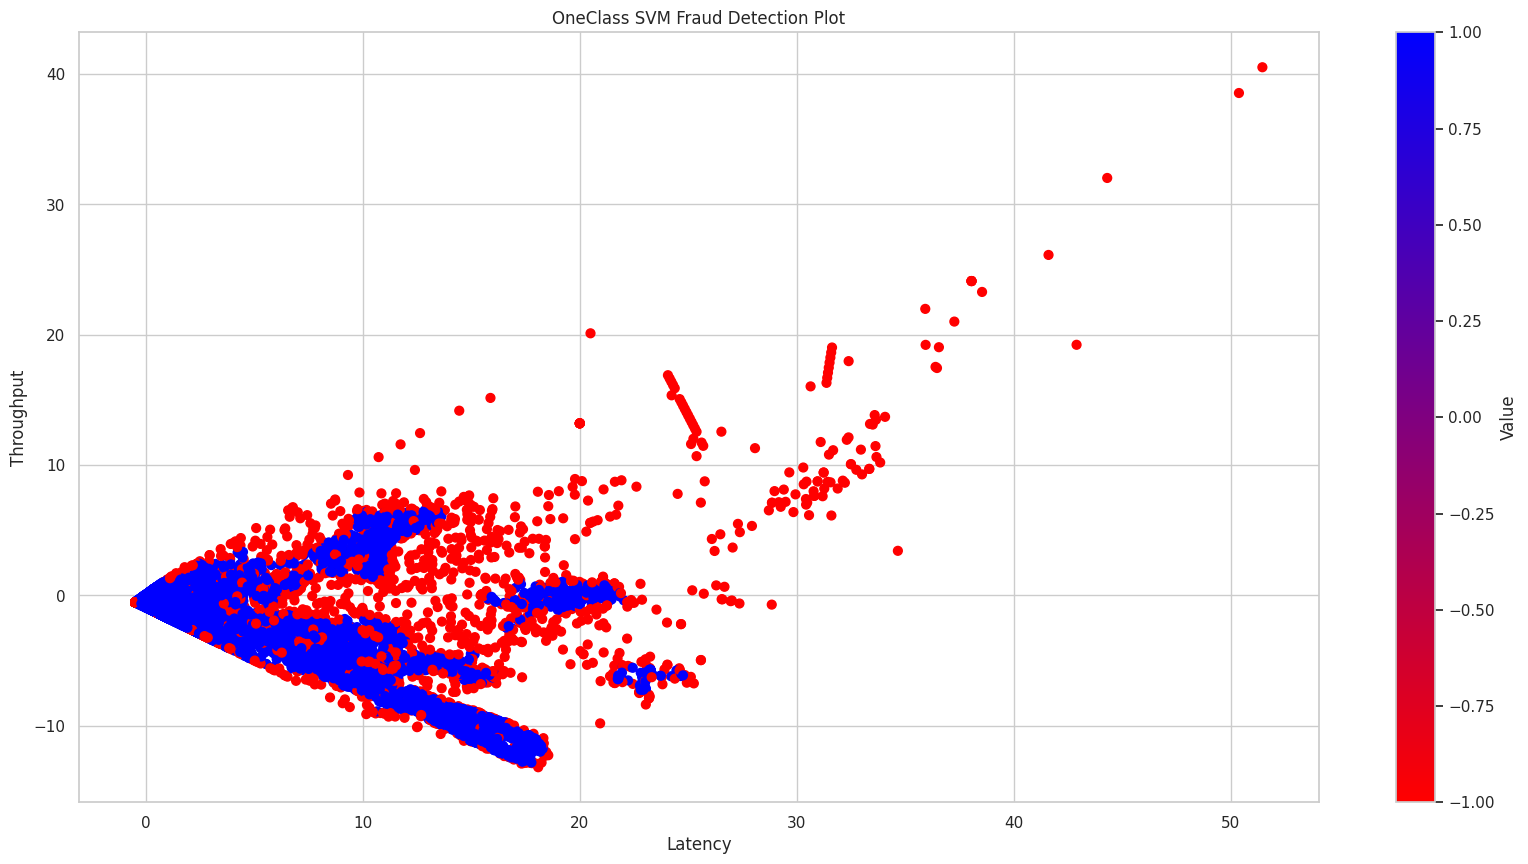

In [12]:
# extract fraud and non-fraud from latent space
fraud_nonfraud_latent = pd.DataFrame(encoded_data)
fraud_nonfraud_latent.columns = ['Latency', 'Throughput']

# prediction
classify = oc_svm.predict(fraud_nonfraud_latent)

# plot
plt.figure(figsize=(20,10))
scatter = plt.scatter(fraud_nonfraud_latent['Latency'], fraud_nonfraud_latent['Throughput'], s=40,
                      c=classify, cmap=LinearSegmentedColormap.from_list('RedBlue', ['red', 'blue']))
plt.colorbar(scatter, label='Value')
plt.title("OneClass SVM Fraud Detection Plot")
plt.xlabel('Latency')
plt.ylabel('Throughput')
plt.show()

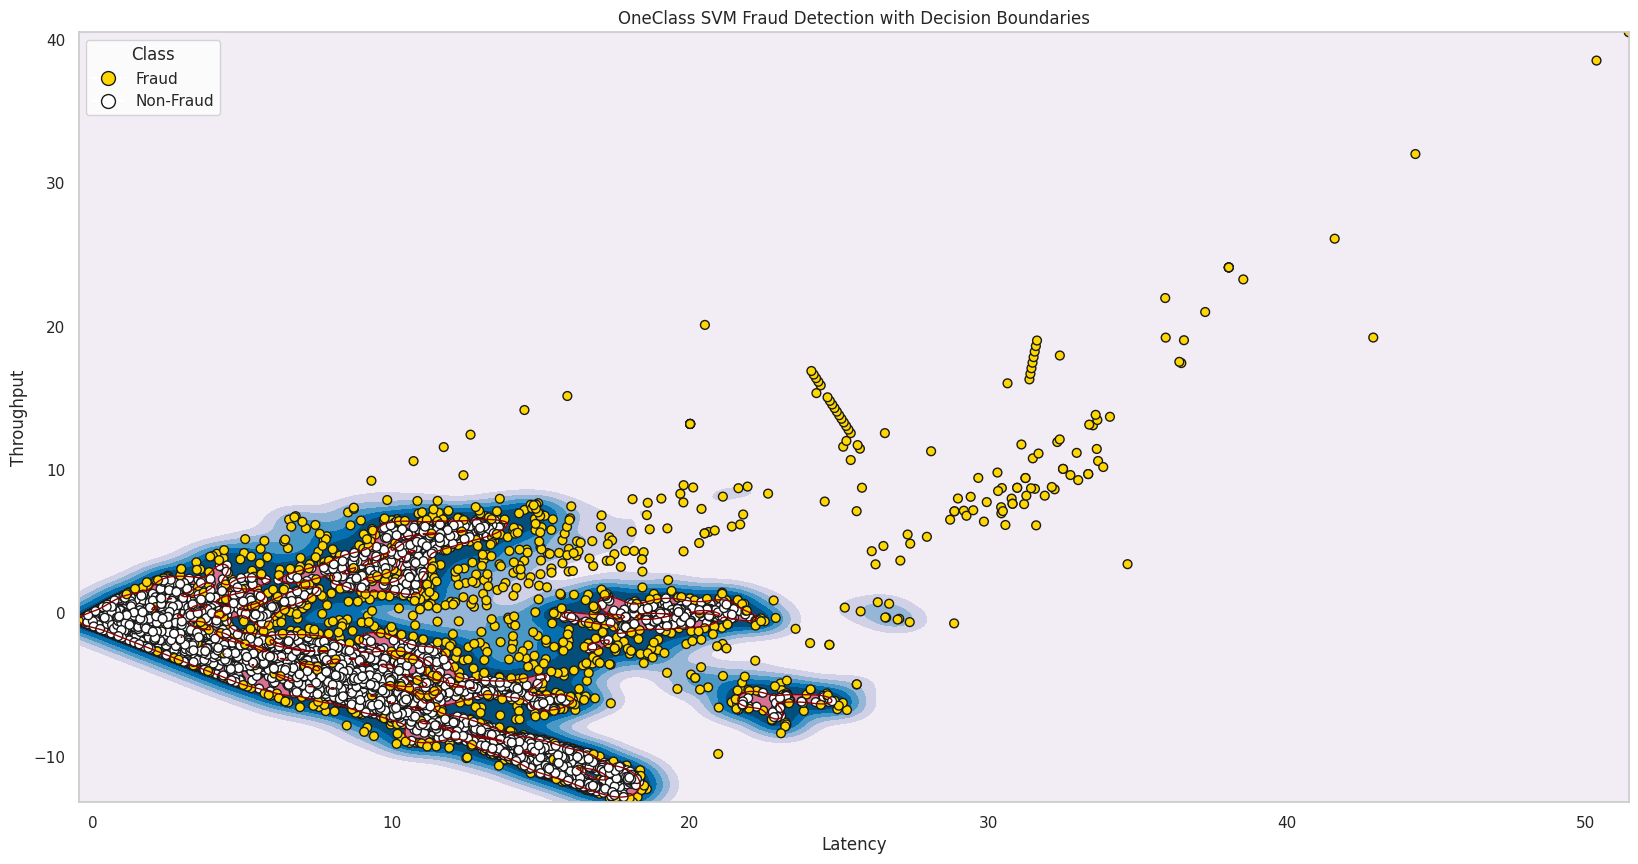

In [13]:
x_d = min(fraud_nonfraud_latent['Latency']); x_u = max(fraud_nonfraud_latent['Latency'])
y_d = min(fraud_nonfraud_latent['Throughput']); y_u = max(fraud_nonfraud_latent['Throughput'])

# figure
plt.figure(figsize=(20,10))
plt.xlim((x_d, x_u))
plt.ylim((y_d, y_u))

# grid
xx, yy = np.meshgrid(np.linspace(x_d, x_u, 500), np.linspace(y_d, y_u, 500))
Z = oc_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# contour
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

# marker
s = 30
colors = ['gold', 'white']

# scatterplot
plt.scatter(fraud_nonfraud_latent['Latency'], fraud_nonfraud_latent['Throughput'],
            c=classify, cmap=LinearSegmentedColormap.from_list("RedWhite", colors), s=40, edgecolors="k")

# legend
labels = ['Fraud', 'Non-Fraud']
legend_handles = [Line2D([0], [0], marker='o', color='w', markeredgecolor="k", markerfacecolor=color, markersize=10, label=label)
                  for color, label in zip(colors, labels)]
plt.legend(handles=legend_handles, title='Class', loc="upper left")

# title and axis titles
plt.title("OneClass SVM Fraud Detection with Decision Boundaries")
plt.xlabel('Latency')
plt.ylabel('Throughput')
plt.show()